- Detect abnormal shipment transit times (e.g., lost shipments).

- i am assuming all dates are in the same timezone

In [92]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

DATA_PATH = Path().cwd().parent / "data"


def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)


shipments_df = read_data("shipments.csv")
po_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")
_datetime_map = {
    "shipments": (shipments_df, ["ship_date", "eta_date", "actual_delivery_date"]),
    "purchase_orders": (po_df, ["order_date", "promised_date"]),
    "transit_events": (transit_events_df, ["event_ts"]),
}
for _, (df, cols) in _datetime_map.items():
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

remove suspect shipments where PO order date is after ship date

In [93]:
# po_order_dates = po_df[["po_id", "order_date"]].rename(columns={"order_date": "po_order_date"})
# shipments_df = shipments_df.merge(po_order_dates, on="po_id", how="left")
# # remove suspect shipments where PO order date is after ship date
# shipments_df = shipments_df.where(
#     shipments_df["po_order_date"].notna()
#     & shipments_df["ship_date"].notna()
#     & (shipments_df["po_order_date"] <= shipments_df["ship_date"])
# )
# # remove null rows created by filtering
# shipments_df = shipments_df.dropna(subset=["po_order_date", "ship_date"])
# shipments_df

In [94]:
ev = transit_events_df.sort_values(['shipment_id','event_ts'])
agg = ev.groupby('shipment_id').agg(
    first_event_ts=('event_ts','first'),
    last_event_ts=('event_ts','last'),
    n_events=('event_ts','count'),
    last_status=('event_status','last')
).reset_index()
shipments = shipments_df.merge(agg, on='shipment_id', how='left')
shipments['transit_observed_days'] = (shipments['last_event_ts'] - shipments['ship_date']).dt.days

shipments

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,first_event_ts,last_event_ts,n_events,last_status,transit_observed_days
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,NaT,NaT,NaN,NaN,NaN
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,2024-03-09 04:00:00,2024-03-09 04:00:00,1.0,Out for Delivery,-165.0
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,2023-02-27 07:00:00,1.0,In Transit,37.0
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2024-05-22 15:00:00,2025-09-02 20:00:00,4.0,Delivered,792.0
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit,NaT,NaT,NaN,NaN,NaN
217496,SH-00217497,PO-0038120,7,Road,EXW,Mexico,ST-01876,2024-08-14,2024-08-27,Delivered,2023-07-30 22:00:00,2023-07-30 22:00:00,1.0,Arrived Hub,-381.0
217497,SH-00217498,PO-0079713,3,Air,DAP,Spain,ST-01330,2023-12-25,2024-01-02,In Transit,2023-09-12 05:00:00,2023-09-12 05:00:00,1.0,Arrived Hub,-104.0
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered,NaT,NaT,NaN,NaN,NaN


In [95]:
# we have transit_observed_days  < 0 which is not possible.
# IF ship_date is moment of shipping out, last_event_ts cannot be before that date.
mask_bad = (shipments['transit_observed_days'] < 0)
shipments = shipments[~mask_bad]
print(f"Removed {mask_bad.sum()} shipments with negative transit days.")
shipments

Removed 64652 shipments with negative transit days.


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,first_event_ts,last_event_ts,n_events,last_status,transit_observed_days
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,NaT,NaT,NaN,NaN,NaN
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,2023-02-27 07:00:00,1.0,In Transit,37.0
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2024-05-22 15:00:00,2025-09-02 20:00:00,4.0,Delivered,792.0
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,NaT,NaT,NaN,NaN,NaN
5,SH-00000006,PO-0052435,9,Road,DAP,Germany,ST-01823,2024-04-19,2024-04-25,In Transit,2023-07-04 00:00:00,2025-08-18 18:00:00,3.0,Customs Hold,486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217493,SH-00217494,PO-0144693,3,Road,DAP,UK,ST-00894,2023-02-04,2023-02-15,In Transit,2023-04-16 18:00:00,2025-07-10 18:00:00,2.0,Created,887.0
217494,SH-00217495,PO-0148870,3,Air,FOB,Malaysia,ST-00088,2024-03-13,2024-03-20,In Transit,2024-08-15 11:00:00,2025-06-30 01:00:00,2.0,Created,474.0
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit,NaT,NaT,NaN,NaN,NaN
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered,NaT,NaT,NaN,NaN,NaN


In [96]:
# we can not work on data without transit records so:
print(f"Removed {shipments['n_events'].isna().sum()} shipments without transit events.")
shipments = shipments[shipments['n_events'].notna()]
shipments

Removed 34541 shipments without transit events.


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,first_event_ts,last_event_ts,n_events,last_status,transit_observed_days
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,2023-02-27 07:00:00,1.0,In Transit,37.0
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2024-05-22 15:00:00,2025-09-02 20:00:00,4.0,Delivered,792.0
5,SH-00000006,PO-0052435,9,Road,DAP,Germany,ST-01823,2024-04-19,2024-04-25,In Transit,2023-07-04 00:00:00,2025-08-18 18:00:00,3.0,Customs Hold,486.0
6,SH-00000007,PO-0089238,4,Sea,DAP,Germany,ST-01749,2023-08-09,2023-09-13,In Transit,2023-05-31 07:00:00,2024-02-29 03:00:00,2.0,Delivered,204.0
9,SH-00000010,PO-0099357,6,Road,DDP,Czechia,ST-00151,2025-01-02,2025-01-13,In Transit,2024-01-06 04:00:00,2025-04-25 04:00:00,4.0,Out for Delivery,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217489,SH-00217490,PO-0017811,3,Road,DAP,Vietnam,ST-00913,2023-05-05,2023-05-20,In Transit,2025-09-13 08:00:00,2025-09-13 08:00:00,1.0,Created,862.0
217492,SH-00217493,PO-0093856,5,Sea,DAP,Spain,ST-00658,2025-02-14,2025-03-21,In Transit,2024-08-02 16:00:00,2025-05-01 13:00:00,2.0,Arrived Hub,76.0
217493,SH-00217494,PO-0144693,3,Road,DAP,UK,ST-00894,2023-02-04,2023-02-15,In Transit,2023-04-16 18:00:00,2025-07-10 18:00:00,2.0,Created,887.0
217494,SH-00217495,PO-0148870,3,Air,FOB,Malaysia,ST-00088,2024-03-13,2024-03-20,In Transit,2024-08-15 11:00:00,2025-06-30 01:00:00,2.0,Created,474.0


In [97]:
# can i  assume that all transit events were captured , and create time_since_last_evvent column (i.e., days since last event till last observed date in table) ?

# deliverd datee is last_event_ts if last_status = Delivered
shipments['delivered_date'] = np.where(
    shipments['last_status'] == 'Delivered',
    shipments['last_event_ts'],
    pd.NaT
)
# only 5k items...
shipments

C:\Users\skibi\AppData\Local\Temp\ipykernel_53676\1900771785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipments['delivered_date'] = np.where(


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,first_event_ts,last_event_ts,n_events,last_status,transit_observed_days,delivered_date
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,2023-02-27 07:00:00,1.0,In Transit,37.0,NaT
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2024-05-22 15:00:00,2025-09-02 20:00:00,4.0,Delivered,792.0,1756843200000000000
5,SH-00000006,PO-0052435,9,Road,DAP,Germany,ST-01823,2024-04-19,2024-04-25,In Transit,2023-07-04 00:00:00,2025-08-18 18:00:00,3.0,Customs Hold,486.0,NaT
6,SH-00000007,PO-0089238,4,Sea,DAP,Germany,ST-01749,2023-08-09,2023-09-13,In Transit,2023-05-31 07:00:00,2024-02-29 03:00:00,2.0,Delivered,204.0,1709175600000000000
9,SH-00000010,PO-0099357,6,Road,DDP,Czechia,ST-00151,2025-01-02,2025-01-13,In Transit,2024-01-06 04:00:00,2025-04-25 04:00:00,4.0,Out for Delivery,113.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217489,SH-00217490,PO-0017811,3,Road,DAP,Vietnam,ST-00913,2023-05-05,2023-05-20,In Transit,2025-09-13 08:00:00,2025-09-13 08:00:00,1.0,Created,862.0,NaT
217492,SH-00217493,PO-0093856,5,Sea,DAP,Spain,ST-00658,2025-02-14,2025-03-21,In Transit,2024-08-02 16:00:00,2025-05-01 13:00:00,2.0,Arrived Hub,76.0,NaT
217493,SH-00217494,PO-0144693,3,Road,DAP,UK,ST-00894,2023-02-04,2023-02-15,In Transit,2023-04-16 18:00:00,2025-07-10 18:00:00,2.0,Created,887.0,NaT
217494,SH-00217495,PO-0148870,3,Air,FOB,Malaysia,ST-00088,2024-03-13,2024-03-20,In Transit,2024-08-15 11:00:00,2025-06-30 01:00:00,2.0,Created,474.0,NaT


In [100]:
print(f'modes of transport: {shipments["mode"].value_counts().to_dict()}') 
print (f'shipment types: {shipments["last_status"].value_counts().to_dict()}')

modes of transport: {'Sea': 41268, 'Road': 35371, 'Air': 29719, 'Rail': 11949}
shipment types: {'In Transit': 29824, 'Delivered': 18691, 'Arrived Hub': 15348, 'Out for Delivery': 13161, 'Created': 9385, 'Picked': 8308, 'Departed Origin': 8286, 'Released': 8273, 'Customs Hold': 7031}


In [ ]:
last_event = shipments['last_event_ts'].max()
shipments["days_since_last_event"] = (last_event - shipments["last_event_ts"]).dt.days

# Dynamic thresholds guided by transport mode and status (sea gaps normal, last-mile gaps are not)
BASE_THRESHOLD_DAYS = 30
mode_thresholds = {
    "Sea": 75,   # ocean legs can run silent for weeks
    "Air": 7,    # 5-7 days without scans is abnormal for air
    "Road": 30,
    "Rail": 35,
}
status_thresholds = {
    "Customs Hold": 90,      # paperwork-driven delays
    "Out for Delivery": 2,   # final-mile gap >48h is suspicious
}


def resolve_threshold(row):
    base = mode_thresholds.get(row["mode"], BASE_THRESHOLD_DAYS)
    status_override = status_thresholds.get(row["last_status"])
    if status_override is None:
        return base
    if row["last_status"] == "Customs Hold":
        return max(base, status_override)
    if row["last_status"] == "Out for Delivery":
        return min(base, status_override)
    return status_override


shipments["dynamic_threshold_days"] = shipments.apply(resolve_threshold, axis=1)
shipments['is_lost_in_transit'] = np.where(
    (shipments['last_status'] != 'Delivered') &
    (shipments['days_since_last_event'] > shipments['dynamic_threshold_days']),
    1,
    0,
)
shipments

C:\Users\skibi\AppData\Local\Temp\ipykernel_53676\3485118389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipments["days_since_last_event"] = (last_event - shipments["last_event_ts"]).dt.days
C:\Users\skibi\AppData\Local\Temp\ipykernel_53676\3485118389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipments['is_lost_in_transit'] = np.where(


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,first_event_ts,last_event_ts,n_events,last_status,transit_observed_days,delivered_date,days_since_last_event,is_lost_in_transit
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,2023-02-27 07:00:00,2023-02-27 07:00:00,1.0,In Transit,37.0,NaT,976,1
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,2024-05-22 15:00:00,2025-09-02 20:00:00,4.0,Delivered,792.0,1756843200000000000,58,0
5,SH-00000006,PO-0052435,9,Road,DAP,Germany,ST-01823,2024-04-19,2024-04-25,In Transit,2023-07-04 00:00:00,2025-08-18 18:00:00,3.0,Customs Hold,486.0,NaT,73,1
6,SH-00000007,PO-0089238,4,Sea,DAP,Germany,ST-01749,2023-08-09,2023-09-13,In Transit,2023-05-31 07:00:00,2024-02-29 03:00:00,2.0,Delivered,204.0,1709175600000000000,609,0
9,SH-00000010,PO-0099357,6,Road,DDP,Czechia,ST-00151,2025-01-02,2025-01-13,In Transit,2024-01-06 04:00:00,2025-04-25 04:00:00,4.0,Out for Delivery,113.0,NaT,188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217489,SH-00217490,PO-0017811,3,Road,DAP,Vietnam,ST-00913,2023-05-05,2023-05-20,In Transit,2025-09-13 08:00:00,2025-09-13 08:00:00,1.0,Created,862.0,NaT,47,1
217492,SH-00217493,PO-0093856,5,Sea,DAP,Spain,ST-00658,2025-02-14,2025-03-21,In Transit,2024-08-02 16:00:00,2025-05-01 13:00:00,2.0,Arrived Hub,76.0,NaT,182,1
217493,SH-00217494,PO-0144693,3,Road,DAP,UK,ST-00894,2023-02-04,2023-02-15,In Transit,2023-04-16 18:00:00,2025-07-10 18:00:00,2.0,Created,887.0,NaT,112,1
217494,SH-00217495,PO-0148870,3,Air,FOB,Malaysia,ST-00088,2024-03-13,2024-03-20,In Transit,2024-08-15 11:00:00,2025-06-30 01:00:00,2.0,Created,474.0,NaT,122,1


In [ ]:
statuses = shipments['last_status'].value_counts()
statuses

last_status
In Transit          29824
Delivered           18691
Arrived Hub         15348
Out for Delivery    13161
Created              9385
Picked               8308
Departed Origin      8286
Released             8273
Customs Hold         7031
Name: count, dtype: int64

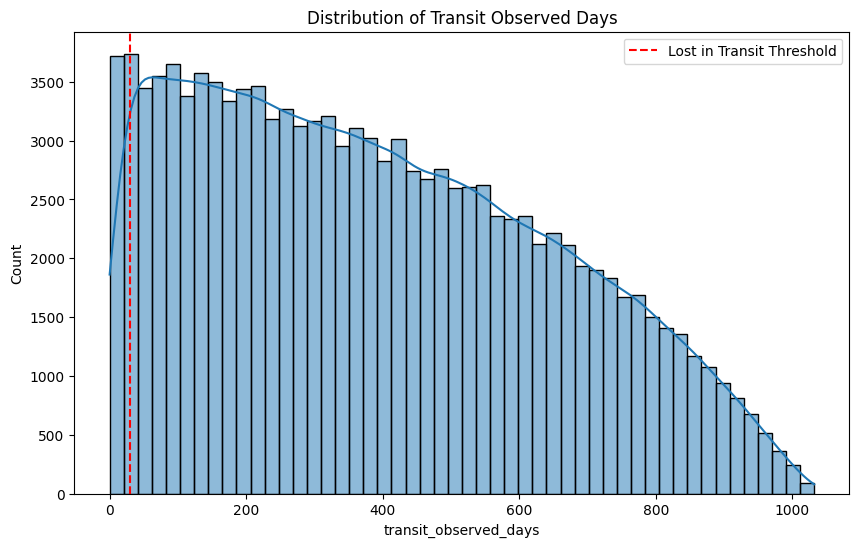

Lost in transit shipments: 89935
Delivered shipments: 18691


In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=shipments, x='transit_observed_days', bins=50, kde=True)
plt.title('Distribution of Transit Observed Days')
# plot line for lost in transit threshold
plt.axvline(x=LOST_IN_TRANSIT_THRESHOLD_DAYS, color='red', linestyle='--', label='Lost in Transit Threshold')
plt.legend()
 
plt.show()
print(f'Lost in transit shipments: {shipments["is_lost_in_transit"].sum()}')
print(f'Delivered shipments: {(shipments["last_status"] == "Delivered").sum()}')

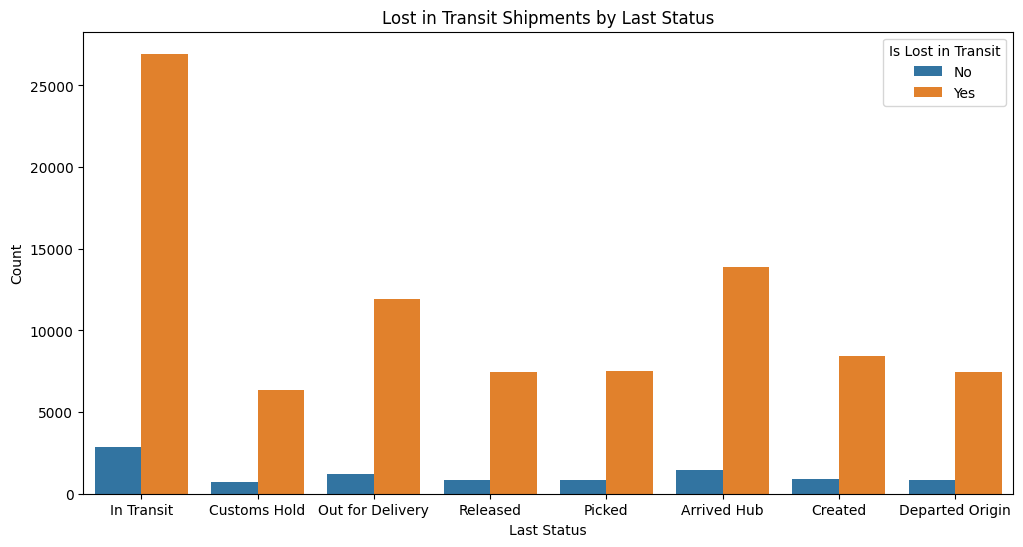

In [ ]:
# lost in transit by status counts

# drop delivered shipments for better visualization
shipments_filtered = shipments[shipments['last_status'] != 'Delivered']

plt.figure(figsize=(12,6))
sns.countplot(data=shipments_filtered, x='last_status', hue='is_lost_in_transit')
plt.title('Lost in Transit Shipments by Last Status')
plt.xlabel('Last Status')
plt.ylabel('Count')
plt.legend(title='Is Lost in Transit', labels=['No', 'Yes'])
plt.show()

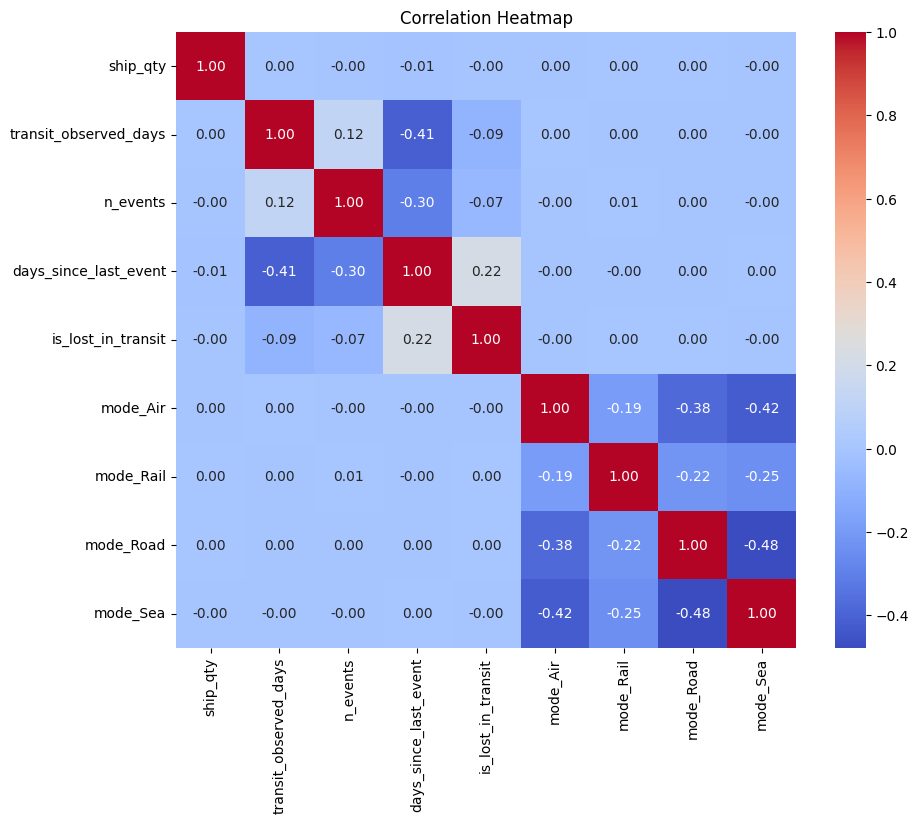

In [ ]:
# VISUALIZATIONS
# 'shipment_id', 'po_id', 'ship_qty', 'mode', 'incoterm',
#       'origin_country', 'dest_site_id', 'ship_date', 'eta_date', 'status',
#       'po_order_date', 'first_event_ts', 'last_event_ts', 'n_events',
#       'last_status', 'transit_observed_days', 'delivered_date',
#       'days_since_last_event', 'is_lost_in_transit'],
# heat map of correlations
viz_data = shipments[[
    'ship_qty',
    'transit_observed_days',
    'n_events',
    'days_since_last_event',
    'is_lost_in_transit',
    'mode', # to be encoded,
    # 'origin_country' # to be encoded

]]
# encode categorical variables
viz_data = pd.get_dummies(viz_data, columns=['mode'])

plt.figure(figsize=(10,8))
corr = viz_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
#merge with site table to get `dest_site_country` 
shipments = shipments.merge(
    sites_df[['site_id', 'country', 'site_type', 'operator']].rename(columns={
        'site_id': 'dest_site_id',
        'country': 'dest_site_country'
    }),
    on='dest_site_id',
    how='left'
)
shipments

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,...,last_event_ts,n_events,last_status,transit_observed_days,delivered_date,days_since_last_event,is_lost_in_transit,dest_site_country,site_type,operator
0,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,...,2023-02-27 07:00:00,1.0,In Transit,37.0,NaT,976,1,Austria,Cell Site,Orange
1,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,...,2025-09-02 20:00:00,4.0,Delivered,792.0,1756843200000000000,58,0,Poland,Warehouse,NaN
2,SH-00000006,PO-0052435,9,Road,DAP,Germany,ST-01823,2024-04-19,2024-04-25,In Transit,...,2025-08-18 18:00:00,3.0,Customs Hold,486.0,NaT,73,1,Netherlands,Warehouse,NaN
3,SH-00000007,PO-0089238,4,Sea,DAP,Germany,ST-01749,2023-08-09,2023-09-13,In Transit,...,2024-02-29 03:00:00,2.0,Delivered,204.0,1709175600000000000,609,0,Austria,Warehouse,NaN
4,SH-00000010,PO-0099357,6,Road,DDP,Czechia,ST-00151,2025-01-02,2025-01-13,In Transit,...,2025-04-25 04:00:00,4.0,Out for Delivery,113.0,NaT,188,1,UK,Cell Site,Vodafone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118302,SH-00217490,PO-0017811,3,Road,DAP,Vietnam,ST-00913,2023-05-05,2023-05-20,In Transit,...,2025-09-13 08:00:00,1.0,Created,862.0,NaT,47,1,Vietnam,Cell Site,Singtel
118303,SH-00217493,PO-0093856,5,Sea,DAP,Spain,ST-00658,2025-02-14,2025-03-21,In Transit,...,2025-05-01 13:00:00,2.0,Arrived Hub,76.0,NaT,182,1,India,Warehouse,NaN
118304,SH-00217494,PO-0144693,3,Road,DAP,UK,ST-00894,2023-02-04,2023-02-15,In Transit,...,2025-07-10 18:00:00,2.0,Created,887.0,NaT,112,1,Chile,Cell Site,Verizon
118305,SH-00217495,PO-0148870,3,Air,FOB,Malaysia,ST-00088,2024-03-13,2024-03-20,In Transit,...,2025-06-30 01:00:00,2.0,Created,474.0,NaT,122,1,Germany,Cell Site,Telefónica


In [ ]:
# check if dest_site_country != origin_country then there are more chances of lost in transit (in perccent)

data = shipments.copy()
data['is_international'] = data['dest_site_country'].fillna('') != data['origin_country'].fillna('')

# aggregate counts and percentage lost
agg = data.groupby('is_international').agg(
    total_shipments=('shipment_id', 'count'),
    lost_shipments=('is_lost_in_transit', 'sum')
)
agg['pct_lost'] = 100 * agg['lost_shipments'] / agg['total_shipments']

display(agg)

# Answer - No it does no.

,total_shipments,lost_shipments,pct_lost
is_international,,,
False,4450,3403,76.471910
True,113857,86532,76.000597


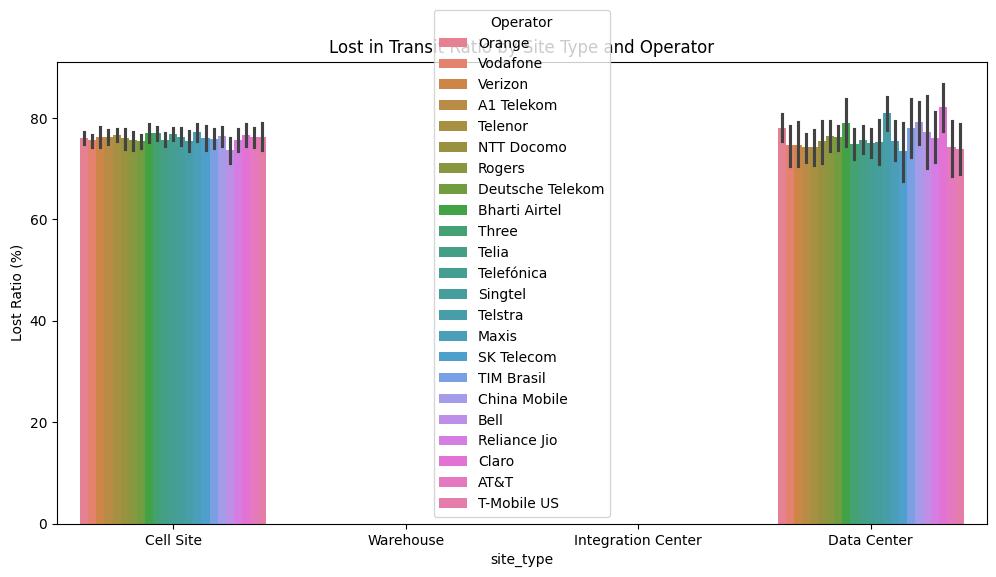

Site Type: Cell Site, Lost in Transit Ratio: 76.12%
Site Type: Warehouse, Lost in Transit Ratio: 75.61%
Site Type: Integration Center, Lost in Transit Ratio: 76.43%
Site Type: Data Center, Lost in Transit Ratio: 76.03%


In [ ]:
# lost ratios by site_type and operator
plt.figure(figsize=(12,6))
sns.barplot(
    data=shipments,
    x='site_type',
    y='is_lost_in_transit',
    hue='operator',
    estimator=lambda x: np.mean(x) * 100
)
plt.ylabel('Lost Ratio (%)')
plt.title('Lost in Transit Ratio by Site Type and Operator')
plt.legend(title='Operator')
plt.show()

# print it
for site_type in shipments['site_type'].unique():
    subset = shipments[shipments['site_type'] == site_type]
    lost_ratio = subset['is_lost_in_transit'].mean() * 100
    print(f"Site Type: {site_type}, Lost in Transit Ratio: {lost_ratio:.2f}%")


In [ ]:
# Flag each transit event as lost in transit when it matches the last recorded event of a shipment
transit_events_flagged = transit_events_df.merge(
    shipments[["shipment_id", "last_event_ts", "is_lost_in_transit"]],
    on="shipment_id",
    how="left"
)
transit_events_flagged["is_last_recorded_event"] = (
    transit_events_flagged["event_ts"] == transit_events_flagged["last_event_ts"]
)
transit_events_flagged["event_lost_in_transit"] = np.where(
    transit_events_flagged["is_last_recorded_event"]
    & (transit_events_flagged["is_lost_in_transit"] == 1),
    1,
    0
)

transit_events_flagged

,shipment_id,event_ts,location_type,event_status,last_event_ts,is_lost_in_transit,is_last_recorded_event,event_lost_in_transit
0,SH-00145406,2023-01-01 00:00:00,On Vehicle,Picked,NaT,NaN,False,0
1,SH-00074867,2023-01-01 00:00:00,Regional Hub,Out for Delivery,2024-11-18 21:00:00,1.0,False,0
2,SH-00132727,2023-01-01 00:00:00,Destination,In Transit,2025-09-22 05:00:00,1.0,False,0
3,SH-00196731,2023-01-01 00:00:00,Seaport,Out for Delivery,NaT,NaN,False,0
4,SH-00061224,2023-01-01 00:00:00,Airport,In Transit,2025-03-28 16:00:00,1.0,False,0
...,...,...,...,...,...,...,...,...
399995,SH-00026250,2025-10-30 23:00:00,Final DC,In Transit,2025-10-30 23:00:00,0.0,True,0
399996,SH-00199670,2025-10-30 23:00:00,Customs,Customs Hold,2025-10-30 23:00:00,0.0,True,0
399997,SH-00209773,2025-10-30 23:00:00,Airport,Delivered,2025-10-30 23:00:00,0.0,True,0
399998,SH-00064076,2025-10-30 23:00:00,Airport,Departed Origin,2025-10-30 23:00:00,0.0,True,0


In [ ]:
# see if there is correlation between any transit event column and lost in transit
# remove all `id` columns
transit_events_flagged_encoded = transit_events_flagged.drop(
    columns=[col for col in transit_events_flagged.columns if col.endswith("_id")]
)

# encode categorical variables
transit_events_flagged_encoded = pd.get_dummies(transit_events_flagged_encoded, drop_first=True)

correlation_matrix = transit_events_flagged_encoded.corr()
correlation_with_lost = correlation_matrix["event_lost_in_transit"].sort_values(ascending=False)
correlation_with_lost
# NO CORRELATION...



event_lost_in_transit            1.000000
is_last_recorded_event           0.831042
event_ts                         0.428897
is_lost_in_transit               0.399391
last_event_ts                    0.346939
event_status_In Transit          0.060875
event_status_Out for Delivery    0.039528
event_status_Picked              0.028554
event_status_Departed Origin     0.027766
event_status_Created             0.027061
event_status_Released            0.026273
event_status_Customs Hold        0.023421
location_type_Seaport            0.002398
location_type_Regional Hub       0.002320
location_type_Customs            0.001923
location_type_Destination        0.001224
location_type_On Vehicle         0.000038
location_type_Final DC          -0.001692
location_type_Origin DC         -0.003458
location_type_Rail Yard         -0.004406
event_status_Delivered          -0.234516
Name: event_lost_in_transit, dtype: float64